In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# Column names
columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4"
] + [f"Soil_Type{i}" for i in range(1, 41)] + ["Cover_Type"]

# Load dataset from UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
df = pd.read_csv(url, header=None, names=columns)

# Save as CSV
df.to_csv("covtype.csv", index=False)

print("Dataset saved as covtype.csv")


Dataset saved as covtype.csv


In [3]:
# 1. Load dataset
df = pd.read_csv("covtype.csv")   # change filename if needed

# 2. Check shape
print("Dataset shape:", df.shape)

# 3. Missing values check
print("Missing values per column:\n", df.isnull().sum())

# 4. Split target (y) and features (X)
X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# 5. Identify one-hot columns
wilderness_cols = [col for col in X.columns if "Wilderness_Area" in col]
soil_cols = [col for col in X.columns if "Soil_Type" in col]

# Numeric columns = everything else
num_cols = [col for col in X.columns if col not in wilderness_cols + soil_cols]

# 6. Scale numeric features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X[num_cols])

# Keep one-hot columns as they are
X_processed = np.concatenate([X_num_scaled, X[wilderness_cols + soil_cols].values], axis=1)

print("Processed features shape:", X_processed.shape)

# 7. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Dataset shape: (581012, 55)
Missing values per column:
 Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10             

In [11]:
# 7. Logistic Regression (multinomial baseline)
log_reg = LogisticRegression(
    multi_class="multinomial",   # handle multiple classes
    solver="lbfgs",              # efficient solver for multinomial
    max_iter=500,                # increase iterations to ensure convergence
    random_state=42,
    n_jobs=-1
)

# Train
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_test)

# Report
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.71      0.70      0.70     42368
           2       0.75      0.80      0.77     56661
           3       0.68      0.80      0.73      7151
           4       0.60      0.43      0.50       549
           5       0.13      0.00      0.01      1899
           6       0.50      0.28      0.36      3473
           7       0.73      0.56      0.63      4102

    accuracy                           0.72    116203
   macro avg       0.59      0.51      0.53    116203
weighted avg       0.71      0.72      0.71    116203



<Figure size 800x600 with 0 Axes>

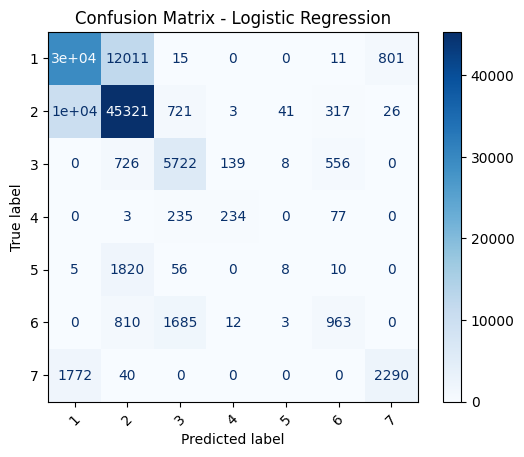

/tmp/ipython-input-2677444245.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(15), palette="viridis")


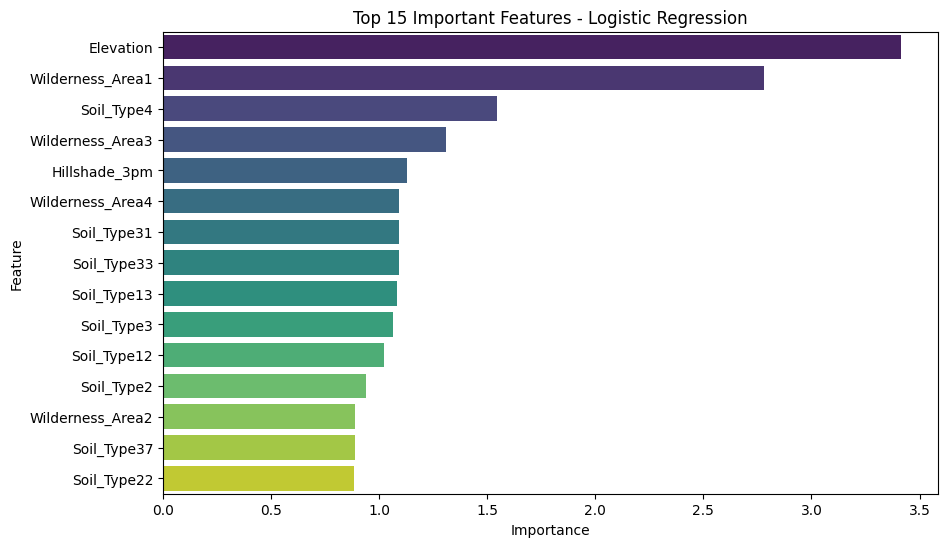

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# --- Confusion Matrix ---
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay.from_estimator(
    log_reg, X_test, y_test,
    cmap="Blues",
    xticks_rotation=45
)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# --- Feature Importance (coefficients) ---
# Logistic Regression gives coefficients for each class vs rest
coefficients = log_reg.coef_

# Take average absolute value across classes (to rank features)
feature_importance = np.mean(np.abs(coefficients), axis=0)

# Match back to feature names
feature_names = num_cols + wilderness_cols + soil_cols
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(15), palette="viridis")
plt.title("Top 15 Important Features - Logistic Regression")
plt.show()


In [4]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.85      0.88       549
           5       0.95      0.77      0.85      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



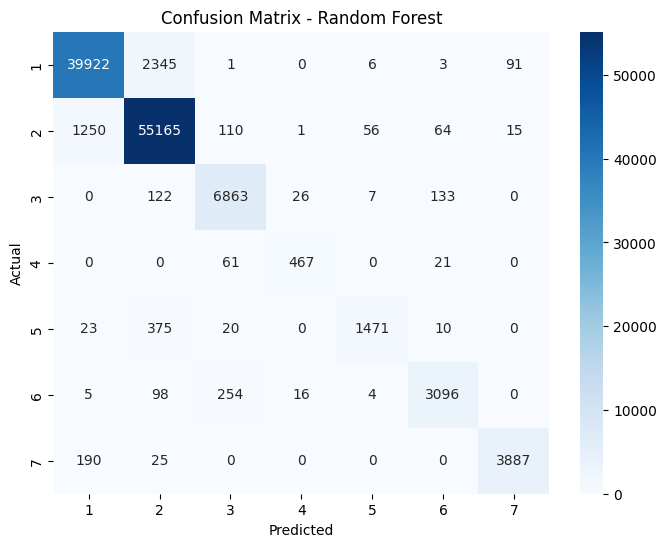

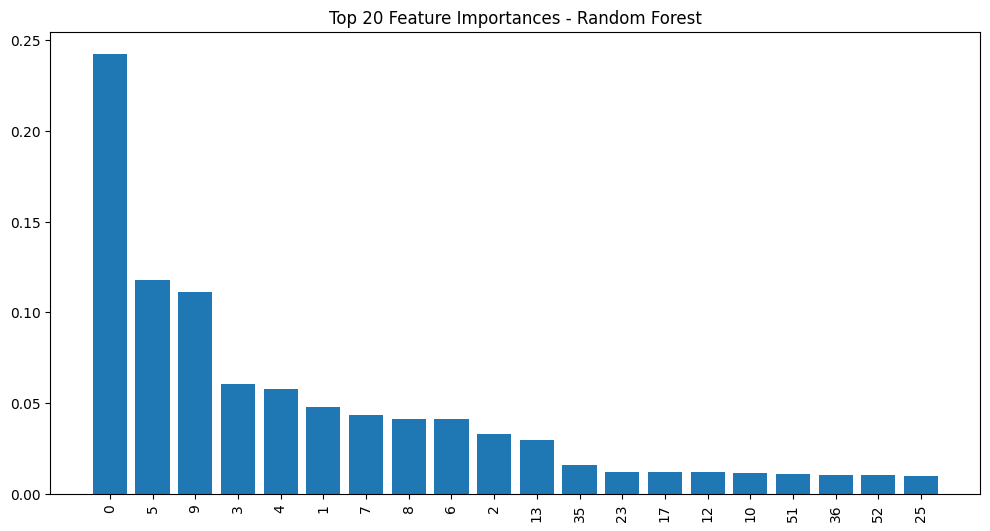

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# -------------------------------
# 2. Feature Importance Visualization
# -------------------------------
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot Top 20 most important features
plt.figure(figsize=(12,6))
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xticks(range(20), indices[:20], rotation=90)
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()

In [6]:
# Shift labels to start from 0
y_train_adj = y_train - 1
y_test_adj = y_test - 1

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

xgb.fit(X_train, y_train_adj)
y_pred = xgb.predict(X_test)

# Shift predictions back to original [1–7]
y_pred_adj = y_pred + 1

print(classification_report(y_test, y_pred_adj))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:14:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.95      0.96      0.96      7151
           4       0.91      0.87      0.89       549
           5       0.94      0.85      0.90      1899
           6       0.94      0.92      0.93      3473
           7       0.97      0.96      0.97      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.93      0.94    116203
weighted avg       0.95      0.95      0.95    116203



In [18]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=5, cv=3, n_jobs=1, random_state=42, verbose=2
)

search.fit(X_train, y_train)

best_rf = search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("Best RF Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("Best Parameters:", search.best_params_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.4min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.3min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.3min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.4min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=

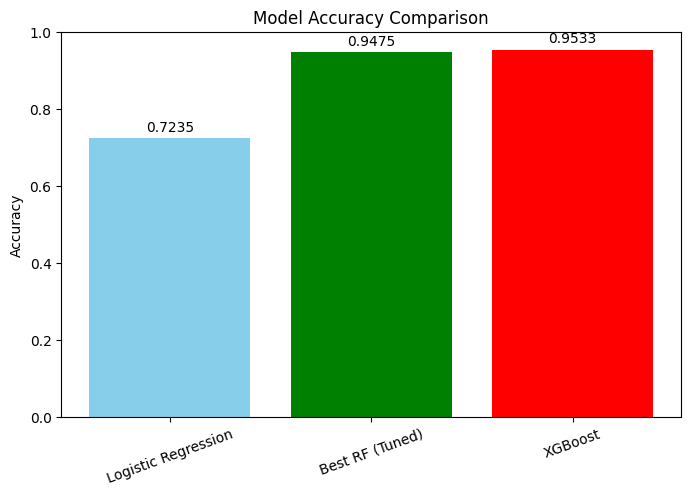

Logistic Regression: 0.7235
Best RF (Tuned): 0.9475
XGBoost: 0.9533


In [21]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Collect accuracies
accuracies = {
    "Logistic Regression": accuracy_score(y_test, y_pred),
    "Best RF (Tuned)": accuracy_score(y_test, y_pred_best_rf),
    "XGBoost": accuracy_score(y_test, y_pred_adj)
}

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=["skyblue","green","red"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.xticks(rotation=20)

# Add accuracy values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.4f}", ha='center', va='bottom')

plt.show()

# Print values too
for model, acc in accuracies.items():
    print(f"{model}: {acc:.4f}")
